In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
import os
from datetime import datetime 

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model Algorithm 
import xgboost as xgb

# --- Configuration ---
MODEL_NAME_PREFIX = "arr_delay" 
TARGET_COLUMN = "ArrivalDelay"
DATA_PATH = '../data/TAS_Airport_Data_2024_cleaned_exploratory.csv'
MODELS_DIR = '../models/'
MODELS_META_DIR = '../models_meta/'

# Create directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(MODELS_META_DIR, exist_ok=True)


# CRISP-DM Phase: Data Understanding (Brief Recap) & Preparation

In [2]:



# 1. Load Data
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df.columns = df.columns.str.strip()

# 2. Define Target Variable (y) and Initial Features (X_initial)
if TARGET_COLUMN not in df.columns:
    raise ValueError(f"Target column '{TARGET_COLUMN}' not found in DataFrame.")

# Drop rows where target is NaN
df.dropna(subset=[TARGET_COLUMN], inplace=True)
print(f"Shape after dropping NaNs in target '{TARGET_COLUMN}': {df.shape}")

y = df[TARGET_COLUMN]
# Drop target, ID, and other potential leakages/outcomes.
# 'ReasonForDelay' is an outcome.
# 'RunwayDelay' might be part of ArrivalDelay itself, or if it's specific taxi-in time, could be a feature. Let's assume it's part of the target for now.
X_initial = df.drop(columns=[TARGET_COLUMN, 'FlightID', 'ReasonForDelay', 'RunwayDelay']) # Consider 'RunwayDelay' carefully

# 3. Feature Engineering
print("\n--- Feature Engineering ---")

# Datetime features from 'ScheduledArrivalTime'
if 'ScheduledArrivalTime' in X_initial.columns:
    X_initial['ScheduledArrivalTime'] = pd.to_datetime(X_initial['ScheduledArrivalTime'], errors='coerce')
    # If 'ScheduledArrivalTime' is critical and unparseable, we might drop the row.
    # For now, SimpleImputer later will handle NaTs if they become NaNs in numerical features.
    
    X_initial['ScheduledArrival_Hour'] = X_initial['ScheduledArrivalTime'].dt.hour
    X_initial['ScheduledArrival_Minute'] = X_initial['ScheduledArrivalTime'].dt.minute
    X_initial['ScheduledArrival_DayOfWeek'] = X_initial['ScheduledArrivalTime'].dt.dayofweek
    X_initial['ScheduledArrival_Month'] = X_initial['ScheduledArrivalTime'].dt.month
    X_initial['ScheduledArrival_DayOfYear'] = X_initial['ScheduledArrivalTime'].dt.dayofyear
    X_initial['ScheduledArrival_Is_Weekend'] = X_initial['ScheduledArrivalTime'].dt.dayofweek.isin([5, 6]).astype(int)
    
    # Drop original datetime string AFTER extracting features
    X_initial = X_initial.drop(columns=['ScheduledArrivalTime'])
    print("Engineered datetime features from ScheduledArrivalTime.")
else:
    print("Warning: 'ScheduledArrivalTime' column not found for feature engineering.")

# Datetime features from 'ScheduledTime' (Departure Time) can also be relevant
if 'ScheduledTime' in X_initial.columns:
    X_initial['ScheduledTime'] = pd.to_datetime(X_initial['ScheduledTime'], errors='coerce')

    X_initial['ScheduledDeparture_Hour'] = X_initial['ScheduledTime'].dt.hour # Renaming to avoid clash if both are used
    X_initial['ScheduledDeparture_DayOfWeek'] = X_initial['ScheduledTime'].dt.dayofweek
    X_initial['ScheduledDeparture_Month'] = X_initial['ScheduledTime'].dt.month
    
    X_initial = X_initial.drop(columns=['ScheduledTime'])
    print("Engineered datetime features from ScheduledTime (Departure).")
else:
    print("Warning: 'ScheduledTime' column not found.")

# Ensure 'DepartureDelay' is present as it's a strong predictor for ArrivalDelay
if 'DepartureDelay' not in X_initial.columns:
    print("Warning: 'DepartureDelay' column not found in X_initial. This is a very important feature for Arrival Delay prediction.")
    # If it's missing, you might need to reconsider your data or impute it,
    # but imputing DepartureDelay to predict ArrivalDelay is circular if not done carefully.
    # For now, we'll proceed, and SimpleImputer will handle it if it's missing in some rows.

# Align X and y after potential drops from datetime parsing or if original NaNs in datetime cols existed
# (dropna on target already done, this handles NaTs from dt conversion if we chose to drop them)
# X_initial.dropna(subset=['ScheduledArrival_Hour'], inplace=True) # Example if this feature is critical
y = y.loc[X_initial.index] # Re-align y with X_initial's current index
print(f"Shape of X_initial after feature engineering: {X_initial.shape}")
print(f"Shape of y after aligning: {y.shape}")


# 4. Identify Feature Types for Preprocessing
numerical_features = X_initial.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_initial.select_dtypes(include=['object', 'category']).columns.tolist()

# Ensure 'DepartureDelay' is in numerical_features if it exists
if 'DepartureDelay' in X_initial.columns and 'DepartureDelay' not in numerical_features:
    # This might happen if it was an object type initially and not converted.
    # Forcing it to numeric if it's a key feature.
    X_initial['DepartureDelay'] = pd.to_numeric(X_initial['DepartureDelay'], errors='coerce')
    numerical_features.append('DepartureDelay') # Assuming it's now numeric
    numerical_features = list(set(numerical_features)) # Remove duplicates if any

print(f"\nIdentified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")

# 5. Split Data into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.2, random_state=42)
print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

# 6. Create Preprocessing Pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the ColumnTransformer
# Ensure the feature lists are derived from X_train.columns to avoid issues with features not in split
active_numerical_features = [col for col in numerical_features if col in X_train.columns]
active_categorical_features = [col for col in categorical_features if col in X_train.columns]

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, active_numerical_features),
    ('cat', categorical_pipeline, active_categorical_features)
], remainder='drop')




Shape after dropping NaNs in target 'ArrivalDelay': (32940, 32)

--- Feature Engineering ---
Engineered datetime features from ScheduledArrivalTime.
Engineered datetime features from ScheduledTime (Departure).
Shape of X_initial after feature engineering: (32940, 35)
Shape of y after aligning: (32940,)

Identified Numerical Features: ['FlightDuration', 'BaggageHandlers', 'GroundCrew', 'FuelTrucks', 'CleaningCrew', 'Passengers', 'SecurityChecks', 'DepartureDelay', 'PreviousFlightDelay', 'AircraftTurnaroundTime', 'CheckInQueueTime', 'SecurityWaitTime', 'BaggageClaimBelts', 'CustomsOfficers', 'ImmigrationOfficers', 'ScheduledArrival_Hour', 'ScheduledArrival_Minute', 'ScheduledArrival_DayOfWeek', 'ScheduledArrival_Month', 'ScheduledArrival_DayOfYear', 'ScheduledArrival_Is_Weekend', 'ScheduledDeparture_Hour', 'ScheduledDeparture_DayOfWeek', 'ScheduledDeparture_Month']
Identified Categorical Features: ['Airline', 'DepartureAirport', 'ArrivalAirport', 'OriginAirport', 'Gate', 'AircraftType', 

#  CRISP-DM Phase: Modeling

In [3]:


# 7. Fit the Preprocessor on the Training Data
print("\n--- Fitting Preprocessor ---")
X_train_processed_np = preprocessor.fit_transform(X_train)
feature_names_processed = list(preprocessor.get_feature_names_out())
X_train_processed = pd.DataFrame(X_train_processed_np, columns=feature_names_processed, index=X_train.index)
print(f"Shape of X_train_processed: {X_train_processed.shape}")

# Transform the Test Data
X_test_processed_np = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed_np, columns=feature_names_processed, index=X_test.index)
print(f"Shape of X_test_processed: {X_test_processed.shape}")

# 8. Define and Train the Model (Example: XGBoost Regressor)
print("\n--- Model Training ---")
xgb_model_arr = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100, # Tune these parameters
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Optional: Hyperparameter Tuning (as in previous notebook)
# grid_search_arr = GridSearchCV(...)
# grid_search_arr.fit(X_train_processed, y_train)
# xgb_model_arr = grid_search_arr.best_estimator_

xgb_model_arr.fit(X_train_processed, y_train)
print("Model training complete.")




--- Fitting Preprocessor ---
Shape of X_train_processed: (26352, 125)
Shape of X_test_processed: (6588, 125)

--- Model Training ---
Model training complete.


# CRISP-DM Phase: Evaluation


--- Model Evaluation ---

--- Training Set Metrics (Arrival Delay) ---
R-squared (R2): 0.5896
Mean Absolute Error (MAE): 4.5760
Root Mean Squared Error (RMSE): 7.0805

--- Test Set Metrics (Arrival Delay) ---
R-squared (R2): 0.4935
Mean Absolute Error (MAE): 3.5328
Root Mean Squared Error (RMSE): 6.4673


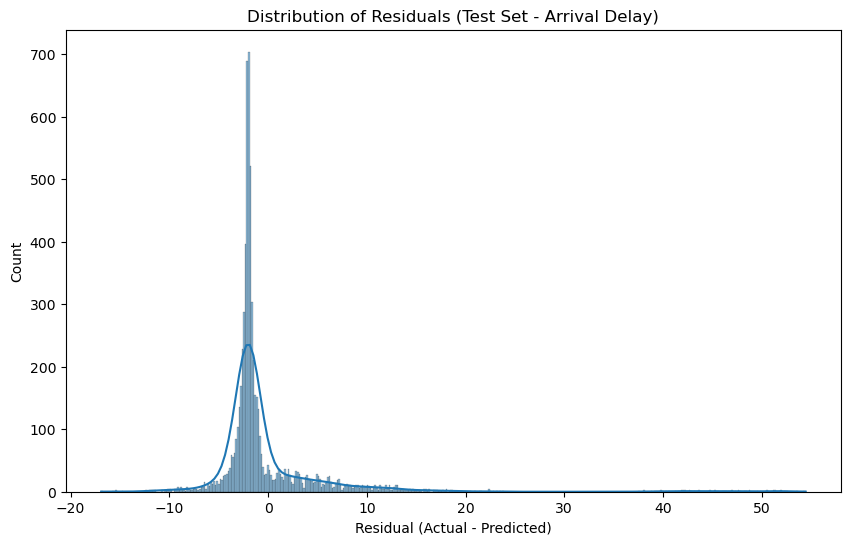

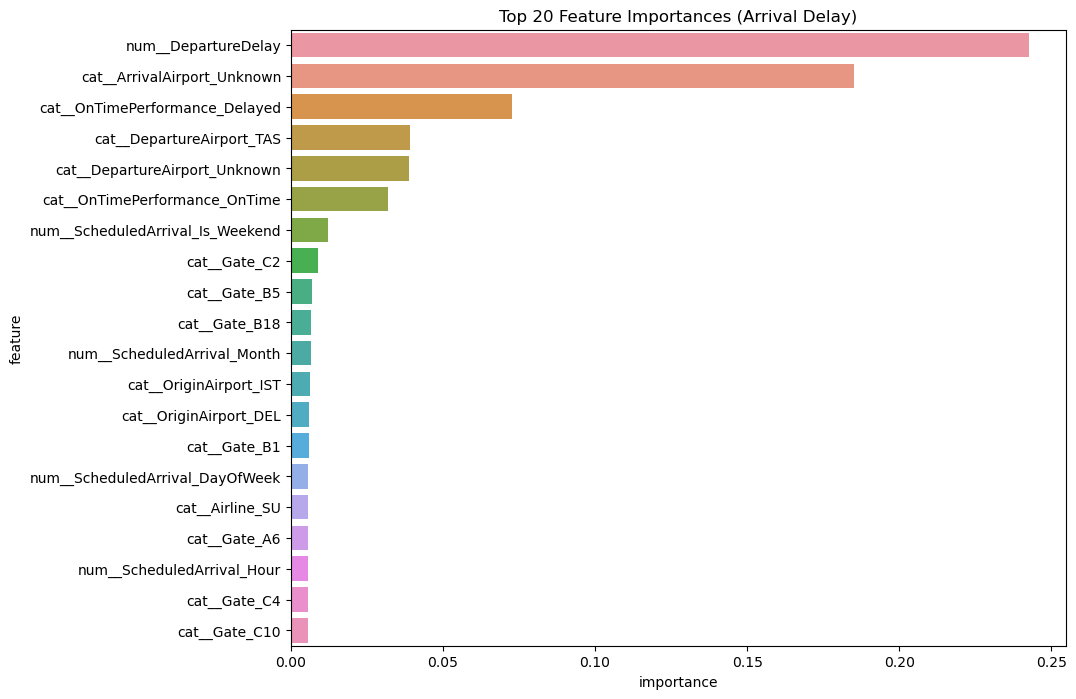

In [4]:
 
print("\n--- Model Evaluation ---")
y_pred_train_arr = xgb_model_arr.predict(X_train_processed)
y_pred_test_arr = xgb_model_arr.predict(X_test_processed)

print("\n--- Training Set Metrics (Arrival Delay) ---")
print(f"R-squared (R2): {r2_score(y_train, y_pred_train_arr):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_train, y_pred_train_arr):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_train, y_pred_train_arr)):.4f}")

print("\n--- Test Set Metrics (Arrival Delay) ---")
print(f"R-squared (R2): {r2_score(y_test, y_pred_test_arr):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_test_arr):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred_test_arr)):.4f}")

# Plotting (similar to departure delay notebook)
plt.figure(figsize=(10, 6))
residuals_arr = y_test - y_pred_test_arr
sns.histplot(residuals_arr, kde=True)
plt.title('Distribution of Residuals (Test Set - Arrival Delay)')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()

# Feature Importance
if hasattr(xgb_model_arr, 'feature_importances_'):
    importances_arr = xgb_model_arr.feature_importances_
    feature_importance_df_arr = pd.DataFrame({'feature': feature_names_processed, 'importance': importances_arr})
    feature_importance_df_arr = feature_importance_df_arr.sort_values(by='importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_arr)
    plt.title('Top 20 Feature Importances (Arrival Delay)')
    plt.show()




# CRISP-DM Phase: Deployment (Saving Artifacts)

In [5]:
print("\n--- Saving Artifacts ---")

# 1. Save the Preprocessor
preprocessor_filename_arr = f"preprocessor_{MODEL_NAME_PREFIX}.pkl" # e.g., preprocessor_arr_delay.pkl
preprocessor_path_arr = os.path.join(MODELS_META_DIR, preprocessor_filename_arr)
joblib.dump(preprocessor, preprocessor_path_arr)
print(f"Preprocessor saved to: {preprocessor_path_arr}")

# 2. Save the list of Processed Feature Names
feature_names_filename_arr = f"feature_names_{MODEL_NAME_PREFIX}.pkl" # e.g., feature_names_arr_delay.pkl
feature_names_path_arr = os.path.join(MODELS_META_DIR, feature_names_filename_arr)
joblib.dump(feature_names_processed, feature_names_path_arr)
print(f"Feature names saved to: {feature_names_path_arr}")

# 3. Save the Trained Model
# This should match the name expected by your dashboard: delay_time_estimation_arr.pkl
final_model_name_for_dashboard_arr = "delay_time_estimation_arr.pkl"
model_path_arr = os.path.join(MODELS_DIR, final_model_name_for_dashboard_arr)
joblib.dump(xgb_model_arr, model_path_arr)
print(f"Trained model saved to: {model_path_arr}")


--- Saving Artifacts ---
Preprocessor saved to: ../models_meta/preprocessor_arr_delay.pkl
Feature names saved to: ../models_meta/feature_names_arr_delay.pkl
Trained model saved to: ../models/delay_time_estimation_arr.pkl
